In [0]:
import os 

import numpy as np
import pandas as pd

import json
import urllib3

import itertools

import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 

In [0]:
DATASET_PATH = 'dataset.csv'

In [0]:
dataset = pd.read_csv(DATASET_PATH, engine='python')

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def compute_plot_cm(model, x_test, y_test, degree=None, normalize_cm = False):
    """ Apply model to data, get and compare predictions, plot confusion matrix """
    
    def get_dog_name(row):
        """ Get column name from One hot """
        for c in y_test.columns:
            if row[c]==1:
                return c
            
    if degree != None:
        poly = PolynomialFeatures(degree=degree)
        x_test_poly = poly.fit_transform(x_test[x_test.columns[:2]])

        x_test = pd.concat([pd.DataFrame(x_test).reset_index(), 
                            pd.DataFrame(x_test_poly).reset_index()], axis=1)
    
    pred = pd.DataFrame(model.predict(x_test),
                     columns=y_test.columns).apply(get_dog_name, axis=1)
    
    true = y_test.apply(get_dog_name, axis=1)
    
    pred = pd.factorize(pred)[0]
    true = pd.factorize(true)[0]
    
    cm = confusion_matrix(pred, true)

    plot_confusion_matrix(cm, classes=Y_test.columns, normalize = normalize_cm)
    

In [0]:
# %%capture
# def plot_decision_boundary(model, X, y, x_column = 'Weight(g)', y_column = 'Height(cm)'):
#     """
#     Use this to plot the decision boundary of a trained model.
#     """
  
#     xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
#     grid = np.c_[xx.ravel(), yy.ravel()]
#     grid = [np.concatenate((gr,[0, 0, 0, 0, 0]), axis=0) for gr in grid]
    
#     probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
#     f, ax = plt.subplots(figsize=(8, 6))
#     contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                         vmin=0, vmax=1)
#     ax_c = f.colorbar(contour)
#     ax_c.set_label("$P(y = 1)$")
#     ax_c.set_ticks([0, .25, .5, .75, 1])

#     ax.scatter(X[x_column], X[y_column], c=y, s=50,
#              cmap="RdBu", vmin=-.2, vmax=1.2,
#              edgecolor="white", linewidth=1)

#     ax.set(aspect="equal",
#          xlim=(-5, 5), ylim=(-5, 5),
#          xlabel="$X_1$", ylabel="$X_2$")
    
# plot_decision_boundary(log_model, X_test, Y_test)

### 1. Data exploration

We observe that the dataset contains 1000 training examples, with both categorical and continuous values and no duplicates. We can also see that the only column that has missing values is 'Height(cm)', where about 20% of the values are missing.

In [0]:
dataset.head()

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
0,Dalmatian,22390.9179,48.0000,12.4664,high,high,short,male,Allen
1,Rottweiler,57351.4114,61.2893,11.1189,med,high,short,female,Shaw
2,Pug,7156.9525,32.2106,12.5911,med,high,short,male,Munoz
3,Australian Shepherd,22877.8776,55.8712,13.3910,high,high,med,male,Jones
4,Dalmatian,24412.9266,NaN,13.2525,high,high,short,male,Smith


In [0]:
dataset.describe()

,Weight(g),Height(cm),Longevity(yrs)
count,1000.000000,805.000000,1000.000000
mean,25351.997161,49.577475,12.233645
std,15656.697592,11.535058,1.838310
min,5719.452200,24.443900,6.971600
25%,7768.587125,37.724800,11.114700
50%,23319.726500,50.792500,12.878650
75%,34818.878725,61.661600,13.468025
max,67226.574800,66.634200,15.869500


In [0]:
dataset.duplicated().any()

False

In [0]:
dataset.isnull().any()

Breed Name         False
Weight(g)          False
Height(cm)          True
Longevity(yrs)     False
Energy level       False
Attention Needs    False
Coat Lenght        False
Sex                False
Owner Name         False
dtype: bool

We observe a very strong correlation between 'Weight(g)' and 'Height(cm)', which it's intuitive. But there is also a strong negative correlation between these two and 'Longevity(yrs)', which could mean that smaller dogs live longer.

In [0]:
dataset.corr()

,Weight(g),Height(cm),Longevity(yrs)
Weight(g),1.000000,0.912427,-0.809397
Height(cm),0.912427,1.000000,-0.726309
Longevity(yrs),-0.809397,-0.726309,1.000000


About the distribution of the continuous values

- 'Weight(g)' could be seen as being formed of 3 Normal Distributions, and they (the distributions) seem to lose precision as the values for weight increased.

- 'Height(cm)' seems to be as well a trimodal distribution, with a clear biggest mode around the value of 50

- 'Longevity(yrs)' it's a bimodal left skewed distribution, the biggest mode being aroud 13 years   

In [0]:
dataset.skew()

Weight(g)         0.583686
Height(cm)       -0.332197
Longevity(yrs)   -0.880368
dtype: float64

Text(0,0.5,'Number of examples')

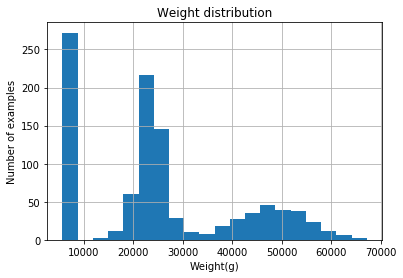

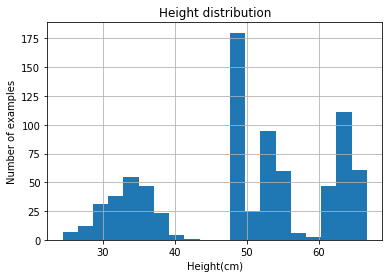

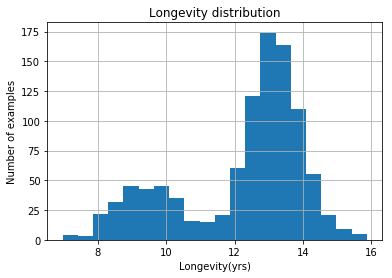

In [0]:
dataset.hist(column='Weight(g)', bins=20)
plt.title('Weight distribution')
plt.xlabel('Weight(g)')
plt.ylabel('Number of examples')

dataset.hist(column='Height(cm)', bins=20)
plt.title('Height distribution')
plt.xlabel('Height(cm)')
plt.ylabel('Number of examples')

dataset.hist(column='Longevity(yrs)', bins=20)
plt.title('Longevity distribution')
plt.xlabel('Longevity(yrs)')
plt.ylabel('Number of examples')


When it comes to predicting the Breed Name, we can see that the number of examples per class
it's balanced, so no need for upsampling or downsampling. 

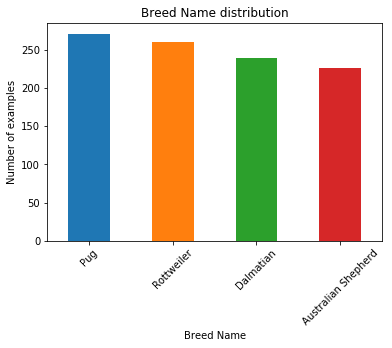

In [0]:
pd.value_counts(dataset['Breed Name']).plot.bar()
plt.title('Breed Name distribution')
plt.xlabel('Breed Name')
plt.ylabel('Number of examples')
plt.xticks(rotation=45)
plt.show()

About the rest of the categorical values, all the features beside 'Sex' seem to be very unbalanced.

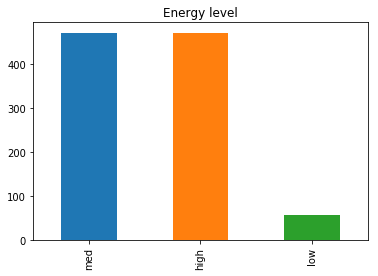

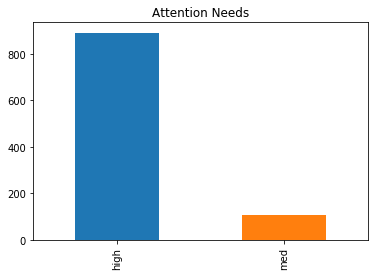

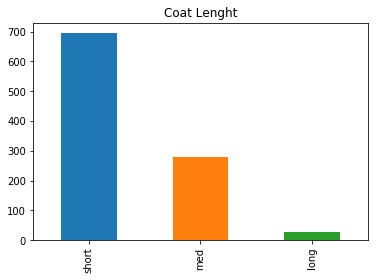

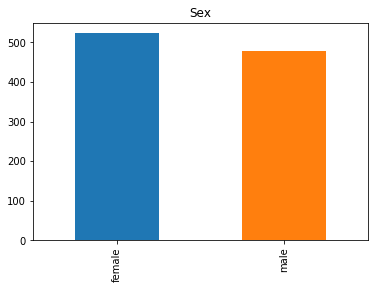

In [0]:
pd.value_counts(dataset['Energy level']).plot.bar()
plt.title('Energy level')
plt.show()

pd.value_counts(dataset['Attention Needs']).plot.bar()
plt.title('Attention Needs')
plt.show()

pd.value_counts(dataset['Coat Lenght']).plot.bar()
plt.title('Coat Lenght')
plt.show()

pd.value_counts(dataset['Sex']).plot.bar()
plt.title('Sex')
plt.show()

We can also see that the some Owner Names are more common than the others. This may be just the normal distribution of the people's name, but it could also worth trying to used the name (not plain, nationality) into breed prediction. 

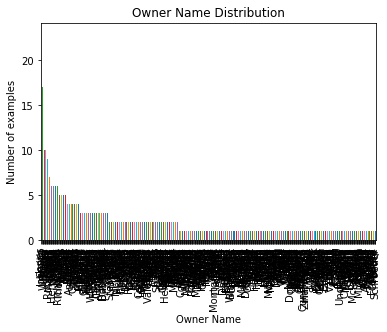

In [0]:
pd.value_counts(dataset['Owner Name']).plot.bar()
plt.title('Owner Name Distribution')
plt.xlabel('Owner Name')
plt.ylabel('Number of examples')

plt.show()

A short analysis shows that top 5 most common Owner's Names are popular american names. There seems to be some difference in the distribution of dogs per each name, but also the sample size is very small. 

In [0]:
top_popular_names = dataset.groupby('Owner Name').count().sort_values(by='Sex',ascending=False).head(5).index

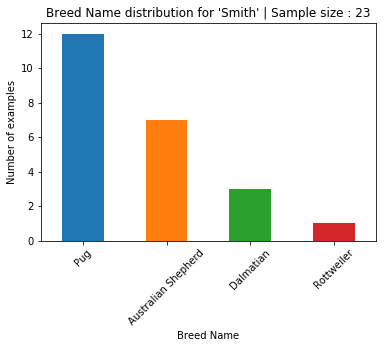

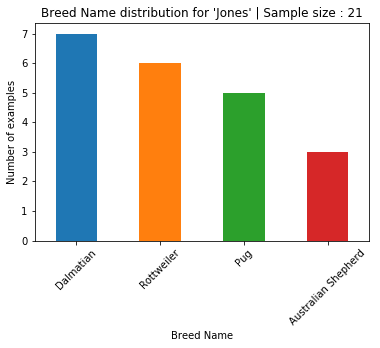

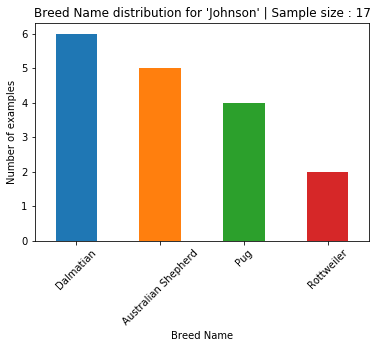

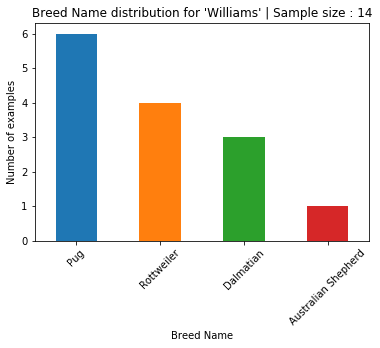

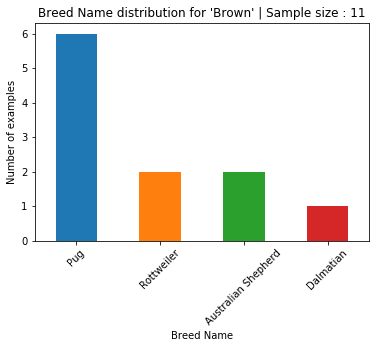

In [0]:
for name in top_popular_names:
    sample_dataset = dataset[dataset['Owner Name'] == name]
    sample_size = sample_dataset.shape[0]
    pd.value_counts(sample_dataset['Breed Name']).plot.bar()
    plt.title('Breed Name distribution for \'' + name + '\' | Sample size : ' + str(sample_size))
    plt.xlabel('Breed Name')
    plt.ylabel('Number of examples')
    plt.xticks(rotation=45)
    plt.show()

All Dalmatians have the same Height(cm), which either means they (the Dalmatians) are cloned or it might be an indicator on corrupt data. Will ignore. 

In [0]:
dataset.groupby(['Breed Name', 'Sex']).count()
dataset.groupby(['Breed Name', 'Sex']).mean()
dataset.groupby(['Breed Name', 'Sex']).std()


Weight(g)  Height(cm)  Longevity(yrs)
Breed Name          Sex                                            
Australian Shepherd female  3172.420379    1.330325        0.621406
                    male    3342.275071    1.469074        0.580198
Dalmatian           female  1870.046933    0.000000        0.605211
                    male    2087.524120    0.000000        0.543278
Pug                 female   553.419558    3.565741        0.892847
                    male     566.322553    3.175825        0.974292
Rottweiler          female  7241.381114    1.507131        0.954941
                    male    7327.320179    1.362927        0.960730

In [0]:
dataset[dataset['Breed Name'] == 'Dalmatian'].mean()

Weight(g)         23239.127120
Height(cm)           48.000000
Longevity(yrs)       13.032117
dtype: float64

In the following plot we can see that dogs can be easily separated using 'Weight(g)' and 'Height(cm)' and we can also see that there is something wrong with the Dalmatians.

Text(0.5,1,'Scatter plot of dog classes')

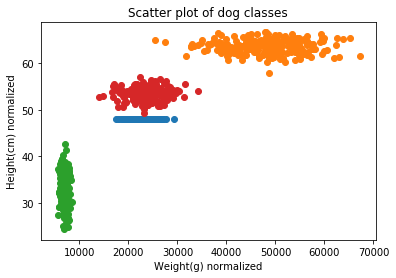

In [0]:
for breed_name in dataset['Breed Name'].unique():
    plt.scatter(dataset[dataset['Breed Name'] == breed_name]['Weight(g)'], dataset[dataset['Breed Name'] == breed_name]['Height(cm)'])
plt.xlabel('Weight(g) normalized')
plt.ylabel('Height(cm) normalized')
plt.title('Scatter plot of dog classes')

Text(0.5,1,'Scatter plot of longevity and weight')

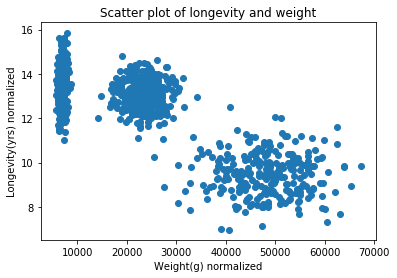

In [0]:
plt.scatter(dataset['Weight(g)'], dataset['Longevity(yrs)'])
plt.xlabel('Weight(g) normalized')
plt.ylabel('Longevity(yrs) normalized')
plt.title('Scatter plot of longevity and weight')

Text(0.5,1,'Scatter plot of longevity and height')

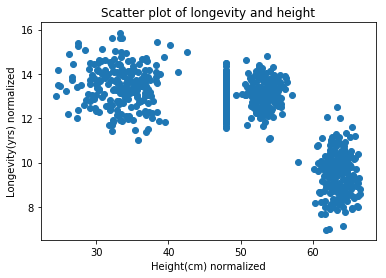

In [0]:
plt.scatter(dataset['Height(cm)'], dataset['Longevity(yrs)'])
plt.xlabel('Height(cm) normalized')
plt.ylabel('Longevity(yrs) normalized')
plt.title('Scatter plot of longevity and height')

## 2. Data cleaning

### 2.1. Replace missing values

My first opinion was to replace the missing values for 'Height(cm)', 
with the mean per each (Breed, Sex) combination, but after computing the mean per each subgrup
I saw that the difference of height per 'Sex' is very small, not relevant. So I'll just use the Breed Name mean for each missing example.

In [0]:
dataset.groupby(['Breed Name', 'Sex']).mean()

Weight(g)  Height(cm)  Longevity(yrs)
Breed Name          Sex                                             
Australian Shepherd female  23596.798777   53.431257       12.984257
                    male    23590.332092   53.346088       13.207503
Dalmatian           female  23229.267167   48.000000       13.117313
                    male    23248.506100   48.000000       12.951077
Pug                 female   6918.414710   33.391663       13.465662
                    male     6999.583562   33.381682       13.472243
Rottweiler          female  48603.542961   63.313206        9.513721
                    male    47209.985696   63.858229        9.399017

In [0]:
dataset['Height(cm)'] = dataset.groupby('Breed Name')['Height(cm)'].transform(lambda x: x.fillna(x.mean()))

In [0]:
# no more missing values
dataset.isna().any()

Breed Name         False
Weight(g)          False
Height(cm)         False
Longevity(yrs)     False
Energy level       False
Attention Needs    False
Coat Lenght        False
Sex                False
Owner Name         False
dtype: bool

### 2.2. Normalization

Considering that the continuous features are very different in scale, this could mess with our classification and regression algorithm when it will compute the distance. I'll normalize those features such that they will be in range [0,1]. Because we don't plan to use this algorithm from new predictions, MinMax normalization seems to be a good choise. 

In [0]:
dataset.describe()

,Weight(g),Height(cm),Longevity(yrs)
count,1000.000000,1000.000000,1000.000000
mean,25351.997161,49.308357,12.233645
std,15656.697592,11.382283,1.838310
min,5719.452200,24.443900,6.971600
25%,7768.587125,37.254075,11.114700
50%,23319.726500,48.000000,12.878650
75%,34818.878725,61.162175,13.468025
max,67226.574800,66.634200,15.869500


In [0]:
from sklearn import preprocessing

COLUMNS_TO_NORMALIZE = ['Weight(g)','Height(cm)','Longevity(yrs)']

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(dataset[COLUMNS_TO_NORMALIZE])

df_normalized = pd.DataFrame(np_scaled, columns=COLUMNS_TO_NORMALIZE)
df_normalized.head()

,Weight(g),Height(cm),Longevity(yrs)
0,0.271049,0.558330,0.617539
1,0.839447,0.873314,0.466099
2,0.023371,0.184087,0.631554
3,0.278966,0.744894,0.721451
4,0.303924,0.558330,0.705886


In [0]:
dataset[COLUMNS_TO_NORMALIZE] = df_normalized

In [0]:
dataset.head()

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
0,Dalmatian,0.271049,0.558330,0.617539,high,high,short,male,Allen
1,Rottweiler,0.839447,0.873314,0.466099,med,high,short,female,Shaw
2,Pug,0.023371,0.184087,0.631554,med,high,short,male,Munoz
3,Australian Shepherd,0.278966,0.744894,0.721451,high,high,med,male,Jones
4,Dalmatian,0.303924,0.558330,0.705886,high,high,short,male,Smith


## 3. Feature engineering

We need to encode categorical values.

For variables that don't have a hierarchy, we will use one hot encoding, and for those that have, we'll use factorization. 

### 3.1 One hot

In [0]:
# we used one hot for sex
COLUMNS_TO_ONE_HOT = ['Sex']
PREFIXES = ['sex']
dataset = pd.get_dummies(dataset, PREFIXES, columns = COLUMNS_TO_ONE_HOT)

### 3.2 Factorization

In [0]:
# we used factorization for the rest, because there is an order
COLUMNS_TO_FACTORIZATION = ['Energy level', 'Attention Needs', 'Coat Lenght']
PREFIXEZ = ['energy','attention', 'coat']


In [0]:
# replace values with custom prefixes, so they'll have desired order then factorized

replace_dict_energy = {'low' : 'a_low', 'med':'b_med', 'high':'c_high'}
replace_dict_attention = {'low' : 'a_low', 'med' : 'b_med', 'high' : 'c_high'}
replace_dict_coat = {'short':'a_short', 'med': 'b_med','long' : 'c_long'}

replace_dict = {'Energy level' : replace_dict_energy,
               'Attention Needs' : replace_dict_attention,
               'Coat Lenght' : replace_dict_coat}

dataset.replace(replace_dict, inplace=True)

In [0]:
for column in COLUMNS_TO_FACTORIZATION:
    dataset[column] = pd.factorize(dataset[column], sort=True)[0]

In [0]:
# we don't need these column for clasification

COLUMNS_TO_DROP = ['Owner Name', 'Longevity(yrs)']


dataset_class = dataset.drop(COLUMNS_TO_DROP, inplace=False, axis=1)

In [0]:
dataset_class.head()

,Breed Name,Weight(g),Height(cm),Energy level,Attention Needs,Coat Lenght,sex_female,sex_male
0,Dalmatian,0.271049,0.558330,2,1,0,0,1
1,Rottweiler,0.839447,0.873314,1,1,0,1,0
2,Pug,0.023371,0.184087,1,1,0,0,1
3,Australian Shepherd,0.278966,0.744894,2,1,1,0,1
4,Dalmatian,0.303924,0.558330,2,1,0,0,1


## 4. Classification

We create one hot encoding for Breed Name as well, so it will be in the right shape

In [0]:
dataset_class = pd.get_dummies(dataset_class, prefix='output', columns=['Breed Name'])

In [0]:
dataset_class.head()

,Weight(g),Height(cm),Energy level,Attention Needs,Coat Lenght,sex_female,sex_male,output_Australian Shepherd,output_Dalmatian,output_Pug,output_Rottweiler
0,0.271049,0.558330,2,1,0,0,1,0,1,0,0
1,0.839447,0.873314,1,1,0,1,0,0,0,0,1
2,0.023371,0.184087,1,1,0,0,1,0,0,1,0
3,0.278966,0.744894,2,1,1,0,1,1,0,0,0
4,0.303924,0.558330,2,1,0,0,1,0,1,0,0


In [0]:
X , Y = dataset_class[dataset_class.columns[:-4]], dataset_class[dataset_class.columns[-4:]]

In [0]:
# we split the data randomly into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state = 42)

Training the model with different values for hyperparameters, so we can choose the best ones. Here I also added polynomial features to help linear models. For clasification, as a metric of evaluation, I will use the accuracy for both train and test subsets. 

### 4.1 Logistic regression

In [0]:
%%capture
logistic_models_conf = [
    {'reg' : 'l1', 'poly' : 'no'},
    {'reg' : 'l2', 'poly' : 'no'},
    {'reg' : 'l1', 'poly' : 1},
    {'reg' : 'l2', 'poly' : 1},
    {'reg' : 'l1', 'poly' : 2},
    {'reg' : 'l2', 'poly' : 2},
    {'reg' : 'l1', 'poly' : 3},
    {'reg' : 'l2', 'poly' : 3},
    {'reg' : 'l1', 'poly' : 4},
    {'reg' : 'l2', 'poly' : 4},
    {'reg' : 'l1', 'poly' : 5},
    {'reg' : 'l2', 'poly' : 5},
]

for index, model_conf in enumerate(logistic_models_conf):
    
    if model_conf['poly'] == 'no':
        X_train_poly = X_train
        X_test_poly = X_test
    else:
    
        poly = PolynomialFeatures(model_conf['poly'])
        X_train_poly = poly.fit_transform(X_train[X_train.columns[:2]])
        X_test_poly = poly.fit_transform(X_test[X_test.columns[:2]])


        X_train_poly = pd.concat([pd.DataFrame(X_train_poly).reset_index().drop('index', axis=1)
                                  , X_train.reset_index().drop('index', axis=1)], axis=1)

        X_test_poly = pd.concat([pd.DataFrame(X_test_poly).reset_index().drop('index', axis=1)
                                 , X_test.reset_index().drop('index', axis=1)], axis=1)
    
    
    log_model = OneVsRestClassifier(LogisticRegression(penalty=model_conf['reg'], random_state=42))
    log_model.fit(X_train_poly, Y_train)

    logistic_models_conf[index]['train_acc'] = log_model.score(X_train_poly, Y_train)
    logistic_models_conf[index]['test_acc'] = log_model.score(X_test_poly, Y_test)    

In [0]:
logistic_results = pd.DataFrame(logistic_models_conf)
logistic_results = logistic_results[['poly', 'reg', 'train_acc', 'test_acc']]

It looks like 'l2' it's doing a really bad job at classification. Here I will choose the 6th combination of paramethers as the best to train a model, because the model that I obtain performed very well on both train and test. Also the model it's not overfitting. 

In [0]:
logistic_results

,poly,reg,train_acc,test_acc
0,no,l1,0.867143,0.806667
1,no,l2,0.862857,0.800000
2,1,l1,0.867143,0.806667
3,1,l2,0.861429,0.803333
4,2,l1,0.940000,0.923333
5,2,l2,0.894286,0.840000
6,3,l1,0.944286,0.926667
7,3,l2,0.897143,0.843333
8,4,l1,0.947143,0.923333
9,4,l2,0.911429,0.856667


### 4.2 Random Forest Decision Tree

In [0]:
%%capture
random_forest_models_conf = [
    {'n_estimators' : 1, 'criterion' : 'gini'},
    {'n_estimators' : 1, 'criterion' : 'entropy'},
    {'n_estimators' : 2, 'criterion' : 'gini'},
    {'n_estimators' : 2, 'criterion' : 'entropy'},
    {'n_estimators' : 3, 'criterion' : 'gini'},
    {'n_estimators' : 3, 'criterion' : 'entropy'},
    {'n_estimators' : 4, 'criterion' : 'gini'},
    {'n_estimators' : 4, 'criterion' : 'entropy'},
    {'n_estimators' : 5, 'criterion' : 'gini'},
    {'n_estimators' : 5, 'criterion' : 'entropy'}
]

for index, model_conf in enumerate(random_forest_models_conf):
        
    forest_model = RandomForestClassifier(n_estimators=model_conf['n_estimators'], 
                                          criterion=model_conf['criterion'])
    forest_model.fit(X_train, Y_train)

    random_forest_models_conf[index]['train_acc'] = forest_model.score(X_train, Y_train)
    random_forest_models_conf[index]['test_acc'] = forest_model.score(X_test, Y_test)    


In [0]:
random_forest_result = pd.DataFrame(random_forest_models_conf)

For the random forest model I will choose one of the first two sets of hyperparameters, since both 'gini' and 'entropy' methods performed well. Even though having a bigger number of estimators increased the accuracy scores, overall it's a small increase and doesn't compensate for the simplicity of just one estimator, one single tree. This way the results could be better explained. 

In [0]:
random_forest_result[['n_estimators', 'criterion', 'train_acc', 'test_acc']]

,n_estimators,criterion,train_acc,test_acc
0,1,gini,0.992857,0.976667
1,1,entropy,0.991429,0.966667
2,2,gini,0.984286,0.950000
3,2,entropy,0.995714,0.990000
4,3,gini,0.998571,0.973333
5,3,entropy,0.998571,0.996667
6,4,gini,0.995714,0.970000
7,4,entropy,0.998571,0.993333
8,5,gini,1.000000,1.000000
9,5,entropy,1.000000,0.993333


### 4.3 KNN

In [0]:
%%capture
knn_models_conf = [
    {'n_neighbors' : 1, 'weights' : 'uniform'},
    {'n_neighbors' : 1, 'weights' : 'distance'},
    {'n_neighbors' : 3, 'weights' : 'uniform'},
    {'n_neighbors' : 3, 'weights' : 'distance'},
    {'n_neighbors' : 5, 'weights' : 'uniform'},
    {'n_neighbors' : 5, 'weights' : 'distance'},
    {'n_neighbors' : 7, 'weights' : 'uniform'},
    {'n_neighbors' : 7, 'weights' : 'distance'},
    {'n_neighbors' : 10, 'weights' : 'uniform'},
    {'n_neighbors' : 10, 'weights' : 'distance'}
]

for index, model_conf in enumerate(knn_models_conf):
        
    knn_model = KNeighborsClassifier(n_neighbors = model_conf['n_neighbors'],
                                     weights = model_conf['weights'])
    knn_model.fit(X_train, Y_train)

    knn_models_conf[index]['train_acc'] = knn_model.score(X_train, Y_train)
    knn_models_conf[index]['test_acc'] = knn_model.score(X_test, Y_test)    

In [0]:
knn_results = pd.DataFrame(knn_models_conf)[['n_neighbors','weights','train_acc','test_acc']]

We cand also see that is KNN is doing a very good job at classifying. I will go for the first model, because it's simpler and it's doing good on both test and train subsets, and it's not overfitting. 

In [0]:
knn_results

,n_neighbors,weights,train_acc,test_acc
0,1,uniform,1.000000,0.983333
1,1,distance,1.000000,0.983333
2,3,uniform,0.984286,0.983333
3,3,distance,1.000000,0.993333
4,5,uniform,0.974286,0.976667
5,5,distance,1.000000,0.983333
6,7,uniform,0.970000,0.960000
7,7,distance,1.000000,0.980000
8,10,uniform,0.920000,0.890000
9,10,distance,1.000000,0.976667


From all the models I would choose to go on with the RandomForestDecisionTree (n_estimators: 1, criterion: gini), not only because it achived the best score, but also because it's the easiest one to explain, and it's also handling missing values very well.

## 5. Regression

For regression we'll try to predict Longevity.

In [0]:
COLUMNS_TO_DROP = ['Owner Name', 'Breed Name']


dataset_reg = dataset.drop(COLUMNS_TO_DROP, inplace=False, axis=1)

In [0]:
X, Y = dataset_reg.loc[:, dataset_reg.columns != 'Longevity(yrs)'], dataset_reg.loc[:, dataset_reg.columns == 'Longevity(yrs)']

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

### 5.1. Linear Regression

Simple Linear Regression has a test score (R^2) of 0.628941, I'll try to improve that with polynomial features of different degrees. 

In [0]:
%%capture
linear_reg_conf = [
    {'reg' : 'l1', 'poly' : 'no'},
    {'reg' : 'l2', 'poly' : 'no'},
    {'reg' : 'l1', 'poly' : 1},
    {'reg' : 'l2', 'poly' : 1},
    {'reg' : 'l1', 'poly' : 2},
    {'reg' : 'l2', 'poly' : 2},
    {'reg' : 'l1', 'poly' : 3},
    {'reg' : 'l2', 'poly' : 3},
    {'reg' : 'l1', 'poly' : 4},
    {'reg' : 'l2', 'poly' : 4},
    {'reg' : 'l1', 'poly' : 5},
    {'reg' : 'l2', 'poly' : 5},
    {'reg' : 'l1', 'poly' : 6},
    {'reg' : 'l2', 'poly' : 6},
    {'reg' : 'l1', 'poly' : 7},
    {'reg' : 'l2', 'poly' : 7},
]

for index, model_conf in enumerate(linear_reg_conf):
    
    if model_conf['poly'] == 'no':
        
        X_train_poly = X_train
        X_test_poly = X_test
    else:
    
        poly = PolynomialFeatures(model_conf['poly'])
        X_train_poly = poly.fit_transform(X_train[X_train.columns[:2]])
        X_test_poly = poly.fit_transform(X_test[X_test.columns[:2]])

        X_train_poly = pd.concat([pd.DataFrame(X_train_poly).reset_index(), X_train.reset_index()], axis=1)
        X_test_poly = pd.concat([pd.DataFrame(X_test_poly).reset_index(), X_test.reset_index()], axis=1)
    
    linear_model = LinearRegression()
    linear_model.fit(X_train_poly, Y_train)

    linear_reg_conf[index]['train_acc'] = linear_model.score(X_train_poly, Y_train)
    linear_reg_conf[index]['test_acc'] = linear_model.score(X_test_poly, Y_test)    

We see that the model achieved better results, especially for the last sets of parameters, but it's now overfitting, so will try to add regularization to the weights to overcome that. 

In [0]:
linear_reg_results = pd.DataFrame(linear_reg_conf)[['reg','poly','train_acc','test_acc']]
linear_reg_results

,reg,poly,train_acc,test_acc
0,l1,no,0.741950,0.732671
1,l2,no,0.741950,0.732671
2,l1,1,0.742449,0.731232
3,l2,1,0.742449,0.731232
4,l1,2,0.789726,0.773000
5,l2,2,0.789726,0.773000
6,l1,3,0.800326,0.782359
7,l2,3,0.800326,0.782359
8,l1,4,0.803616,0.776458
9,l2,4,0.803616,0.776458


In [0]:
%%capture
ridge_reg_conf = [
    {'reg' : 'l1', 'poly' : 7,'model' : 'ridge' ,'alpha' : 0.25},
    {'reg' : 'l1', 'poly' : 7,'model' : 'ridge' ,'alpha' : 0.5},
    {'reg' : 'l1', 'poly' : 7,'model' : 'ridge' ,'alpha' : 0.75},
    {'reg' : 'l1', 'poly' : 7,'model' : 'ridge' ,'alpha' : 1},
    {'reg' : 'l1', 'poly' : 7,'model' : 'lasso' ,'alpha' : 0.25},
    {'reg' : 'l1', 'poly' : 7,'model' : 'lasso' ,'alpha' : 0.5},
    {'reg' : 'l1', 'poly' : 7,'model' : 'lasso' ,'alpha' : 0.75},
    {'reg' : 'l1', 'poly' : 7,'model' : 'lasso' ,'alpha' : 1},
]


for index, model_conf in enumerate(ridge_reg_conf):
    
    if model_conf['poly'] == 'no':
        X_train_poly = X_train
        X_test_poly = X_test
    else:
    
        poly = PolynomialFeatures(model_conf['poly'])
        X_train_poly = poly.fit_transform(X_train[X_train.columns[:2]])
        X_test_poly = poly.fit_transform(X_test[X_test.columns[:2]])

        X_train_poly = pd.concat([pd.DataFrame(X_train_poly).reset_index(), X_train.reset_index()], axis=1)
        X_test_poly = pd.concat([pd.DataFrame(X_test_poly).reset_index(), X_test.reset_index()], axis=1)
    
    if model_conf['model'] == 'ridge':
        ModelClass = Ridge
    else:
        ModelClass = Lasso
    
    linear_model = ModelClass(alpha=model_conf['alpha'])
    linear_model.fit(X_train_poly, Y_train)

    ridge_reg_conf[index]['train_acc'] = linear_model.score(X_train_poly, Y_train)
    ridge_reg_conf[index]['test_acc'] = linear_model.score(X_test_poly, Y_test)


Defineatly Ridge Regression it's the way to go. And we see that the overall R^2 score decreased a little, but we decreased the difference between train and test score, which means that the model generalized better. 
I will choose the first model (l1	7	ridge	0.25), since it has a good score on both train and test.

In [0]:
ridge_reg_conf = pd.DataFrame(ridge_reg_conf)[['reg','poly','model','alpha','train_acc','test_acc']]
ridge_reg_conf

,reg,poly,model,alpha,train_acc,test_acc
0,l1,7,ridge,0.25,0.799434,0.786164
1,l1,7,ridge,0.50,0.797650,0.784848
2,l1,7,ridge,0.75,0.796444,0.783900
3,l1,7,ridge,1.00,0.795542,0.783174
4,l1,7,lasso,0.25,0.002329,0.003050
5,l1,7,lasso,0.50,0.002158,0.002339
6,l1,7,lasso,0.75,0.001871,0.001497
7,l1,7,lasso,1.00,0.001513,0.000641


### 5.2. KNN regressor

In [0]:
%%capture
knn_reg_models_conf = [
    {'n_neighbors' : 1, 'weights' : 'uniform'},
    {'n_neighbors' : 1, 'weights' : 'distance'},
    {'n_neighbors' : 2, 'weights' : 'uniform'},
    {'n_neighbors' : 2, 'weights' : 'distance'},
    {'n_neighbors' : 3, 'weights' : 'uniform'},
    {'n_neighbors' : 3, 'weights' : 'distance'},
    {'n_neighbors' : 4, 'weights' : 'uniform'},
    {'n_neighbors' : 4, 'weights' : 'distance'},
    {'n_neighbors' : 5, 'weights' : 'uniform'},
    {'n_neighbors' : 5, 'weights' : 'distance'},
    {'n_neighbors' : 100, 'weights' : 'uniform'},
    {'n_neighbors' : 100, 'weights' : 'distance'}
]

for index, model_conf in enumerate(knn_reg_models_conf):
        
    knn_model = KNeighborsRegressor(n_neighbors = model_conf['n_neighbors'],
                                     weights = model_conf['weights'])
    knn_model.fit(X_train, Y_train)

    knn_reg_models_conf[index]['train_acc'] = knn_model.score(X_train, Y_train)
    knn_reg_models_conf[index]['test_acc'] = knn_model.score(X_test, Y_test)

For kkn regression, I will choose the third model (2, uniform) since it has the lowest overfitting, and both train and test scores are good.

In [0]:
pd.DataFrame(knn_reg_models_conf)[['n_neighbors','weights','train_acc','test_acc']]

,n_neighbors,weights,train_acc,test_acc
0,1,uniform,1.000000,0.596651
1,1,distance,1.000000,0.596651
2,2,uniform,0.905504,0.710830
3,2,distance,1.000000,0.704882
4,3,uniform,0.867355,0.732801
5,3,distance,1.000000,0.730640
6,4,uniform,0.847946,0.750790
7,4,distance,1.000000,0.744753
8,5,uniform,0.836991,0.762871
9,5,distance,1.000000,0.756094


From the two models used for regression, I will go with KNN regressor, since it got better scores, and lower overfitting score.

## 6. Extra - Adding Owner's sex for breed classification

I want to test the hypotesis that owner sex could help to predict the dog breed. (ex : Males tend to own a particular breed). In this scope I used the api from (https://www.genderize.io) to get the sex for each owner name. Entries that were not found there (83) were introduced manually from (https://www.genderchecker.com/search.aspx). The result was after saved to the owner_sex.csv.

In [0]:
# def get_owner_gender(owner_10_list):
#     ow = owner_10_list
#     request_string = 'https://api.genderize.io/?name[0]={}&name[1]={}&name[2]={}&name[3]={}&name[4]={}&name[5]={}&name[6]={}&name[7]={}&name[8]={}&name[9]={}'.format(*ow)
#     contents = urllib.request.urlopen(request_string).read()
#     return json.loads(contents.decode())

# result = []
# request_no = 0
# for names in name_splits:
#     request_no += 1 
#     print(request_no)
#     result = result + get_owner_gender(names)
    
# owner_sex_df = pd.DataFrame(result)
# owner_sex_df_no_dup = owner_sex_df.drop_duplicates()
# owner_sex_df_no_dup.to_csv('owner_sex.csv', index=False)

# owner_sex_df_no_dup['gender'].value_counts()
# owner_sex_df_no_dup.isna().sum()

In [0]:
owner_sex_df = pd.read_csv('owner_sex.csv')

In [0]:
# we don't need these column for clasification

COLUMNS_TO_DROP = ['Longevity(yrs)']


dataset_class = dataset.drop(COLUMNS_TO_DROP, inplace=False, axis=1)

In [0]:
dataset_class['owner_sex'] = dataset_class.apply(lambda row : owner_sex_df[owner_sex_df['name'] == row['Owner Name']]['gender'].values[0], axis=1)

In [0]:
dataset_class.groupby(['Breed Name', 'owner_sex']).count()

Weight(g)  Height(cm)  Energy level  \
Breed Name          owner_sex                                        
Australian Shepherd female            45          45            45   
                    male             182         182           182   
Dalmatian           female            47          47            47   
                    male             193         193           193   
Pug                 female            48          48            48   
                    male             224         224           224   
Rottweiler          female            45          45            45   
                    male             216         216           216   

                               Attention Needs  Coat Lenght  Owner Name  \
Breed Name          owner_sex                                             
Australian Shepherd female                  45           45          45   
                    male                   182          182         182   
Dalmatian           female                  47           47          47   
                    male                   193          193         193   
Pug                 female                  48           48          48   
                    male                   224          224         224   
Rottweiler          female                  45           45          45   
                    male                   216          216         216   

                               sex_female  sex_male  
Breed Name          owner_sex                        
Australian Shepherd female             45        45  
                    male              182       182  
Dalmatian           female             47        47  
                    male              193       193  
Pug                 female             48        48  
                    male              224       224  
Rottweiler          female             45        45  
                    male              216       216

In [0]:
dataset_class = pd.get_dummies(dataset_class, prefix='owner_sex', columns=['owner_sex'])

In [0]:
dataset_class = pd.get_dummies(dataset_class, prefix='output', columns=['Breed Name'])

In [0]:
dataset_class.drop('Owner Name', inplace=True, axis=1)

In [0]:
X , Y = dataset_class[dataset_class.columns[:-4]], dataset_class[dataset_class.columns[-4:]]

In [0]:
# we split the data randomly into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state = 42)

In [0]:
%%capture
logistic_models_conf_update = [
    {'reg' : 'l1', 'poly' : 'no'},
    {'reg' : 'l2', 'poly' : 'no'},
    {'reg' : 'l1', 'poly' : 1},
    {'reg' : 'l2', 'poly' : 1},
    {'reg' : 'l1', 'poly' : 2},
    {'reg' : 'l2', 'poly' : 2},
    {'reg' : 'l1', 'poly' : 3},
    {'reg' : 'l2', 'poly' : 3},
    {'reg' : 'l1', 'poly' : 4},
    {'reg' : 'l2', 'poly' : 4},
    {'reg' : 'l1', 'poly' : 5},
    {'reg' : 'l2', 'poly' : 5},
]

for index, model_conf in enumerate(logistic_models_conf_update):
    
    if model_conf['poly'] == 'no':
        X_train_poly = X_train
        X_test_poly = X_test
    else:
    
        poly = PolynomialFeatures(model_conf['poly'])
        X_train_poly = poly.fit_transform(X_train[X_train.columns[:2]])
        X_test_poly = poly.fit_transform(X_test[X_test.columns[:2]])


        X_train_poly = pd.concat([pd.DataFrame(X_train_poly).reset_index().drop('index', axis=1)
                                  , X_train.reset_index().drop('index', axis=1)], axis=1)

        X_test_poly = pd.concat([pd.DataFrame(X_test_poly).reset_index().drop('index', axis=1)
                                 , X_test.reset_index().drop('index', axis=1)], axis=1)
    
    
    log_model = OneVsRestClassifier(LogisticRegression(penalty=model_conf['reg'], random_state=42))
    log_model.fit(X_train_poly, Y_train)

    logistic_models_conf_update[index]['train_acc'] = log_model.score(X_train_poly, Y_train)
    logistic_models_conf_update[index]['test_acc'] = log_model.score(X_test_poly, Y_test)    

In [0]:
logistic_models_conf_update = pd.DataFrame(logistic_models_conf_update)[['reg','poly','train_acc','test_acc']]
both_logistics = logistic_models_conf_update.reset_index().join(linear_reg_results.reset_index(), lsuffix='_updated', rsuffix='_old')

In [0]:
acc_difference = (both_logistics['test_acc_updated'] - both_logistics['test_acc_old']).values

In [0]:
from scipy.stats import sem, t
from scipy import mean

confidence = 0.95
n = len(acc_difference)
m = mean(acc_difference)
std_err = sem(acc_difference)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start_value = m - h
end_value = m + h

print (start_value)
print (end_value)

0.0771656029836
0.130341720978


After I trained the Logistic regression classifier of the new data, I computed the difference between the old values and the new ones (using the owner's sex). The 95% confidence interval is [7%, 13%]. Both ends on the interval being positive and far from zero, we could say that the owner's sex it's an improvement for the classification problem.